In [10]:
import MySQLdb
import sys
import os
import subprocess
import bz2
import re 
import pandas as pd
import matplotlib.pyplot as plt

# Virtual machine IP adress
HOST            = "148.60.11.195"

## MySQL user
DB_USER         = "script2"

## MySQL password
DB_PASSWD       = "ud6cw3xNRKnrOz6H"


# Create a new kernel instance from the physical kernel
def compute_kernel(cid):
    try:
        socket = MySQLdb.connect(HOST, DB_USER, DB_PASSWD, "IrmaDB_result")
        cursor = socket.cursor()
        
       
        query = "SELECT compiled_kernel_version, compiled_kernel_size, config_file FROM compilations WHERE cid = %d" % cid
        cursor.execute(query)
        entry = cursor.fetchone()

        if entry is not None:
            return entry
    
    except Exception as e:
        print(str(e),"\n" + "Unable to connect to database c = " + str(cid), file=sys.stderr)
        exit(-1)
        
    finally:
        cursor.close()
        socket.close()
    
    return None

def count_active_options(conf):
    #lines = conf.splitlines()
    #n = 0
    #for line in lines:
    #    if line.startswith("CONFIG"):            
    #        n = n + 1         
    #return n
    return len(re.findall("=y", conf))

ksizes_tiny = pd.DataFrame(columns=['Kernel_version', 'size', 'tiny_options'])
# 30
cids = [38, 35, 40, 41, 42, 61, 57, 54, 72, 73, 74] # cids of tiny kernels
i = 0
for cid in cids:
    r = compute_kernel(cid)
    kversion = r[0]
    ksize = r[1]
    conf = bz2.decompress(r[2]).decode('ascii')    
    noptions = count_active_options(conf)
    ksizes_tiny.loc[i] = ("linux-" + str(kversion), ksize, noptions)
    i = i + 1
    
ksizes_tiny

,Kernel_version,size,tiny_options
0,linux-4.15.1,11542064,247
1,linux-4.20.1,11555432,258
2,linux-4.13.1,7317008,240
3,linux-4.14.1,7317552,243
4,linux-4.16.1,11548664,251
5,linux-4.18.1,11553296,255
6,linux-4.17.1,11551280,253
7,linux-4.12.1,7320416,232
8,linux-4.10.1,7309440,226
9,linux-4.11.1,7316360,231


In [11]:


df_okernels = pd.read_csv("kernel_options.csv")
df_okernels_x86 = df_okernels[df_okernels['ARCH'] == 'x86']

df_integrated_evokernel = pd.merge(ksizes_tiny, df_okernels_x86, on='Kernel_version').sort_values(by='Kernel_version')
# proper/cleaning 
df_integrated_evokernel = df_integrated_evokernel.reset_index(drop=True).drop(columns=["Sumtotkernel", "ARCH"], axis=1) 
#df_okernels_x86["kernel_version"] = df_okernels_x86["Kernel_version"].str.replace("linux-", "", case = False) 
#plt.figure(figsize=(15, 15))
#df_integrated_evokernel.plot(y=['nb_options', 'tiny_options'], figsize=(15, 8), style='.')
#plt.xticks(ticks=df_integrated_evokernel.index.values, labels=df_integrated_evokernel['Kernel_version'].str.replace("linux-", "", case = False))
#df_integrated_evokernel.plot(y='size', figsize=(15, 8), style='.')
#plt.xticks(ticks=df_integrated_evokernel.index.values, labels=df_integrated_evokernel['Kernel_version'].str.replace("linux-", "", case = False))
#plt.show()

In [12]:
df_integrated_evokernel.sort_values(by="Kernel_version")

,Kernel_version,size,tiny_options,nb_options
0,linux-4.10.1,7309440,226,12216
1,linux-4.11.1,7316360,231,12377
2,linux-4.12.1,7320416,232,12606
3,linux-4.13.1,7317008,240,12797
4,linux-4.14.1,7317552,243,12946
5,linux-4.15.1,11542064,247,13021
6,linux-4.16.1,11548664,251,13130
7,linux-4.17.1,11551280,253,13099
8,linux-4.18.1,11553296,255,13220
9,linux-4.19.1,11551920,255,13400


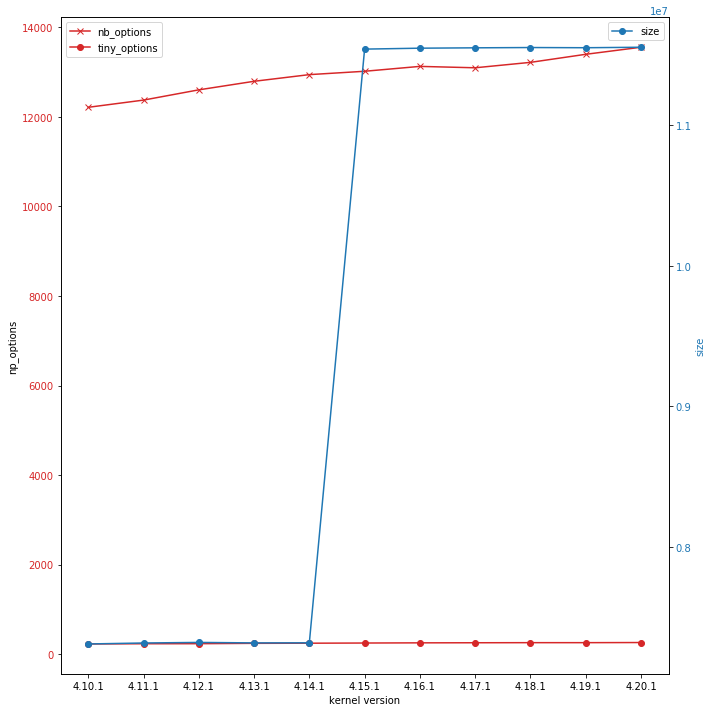

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 10))

color = 'tab:red'
color2 = 'tab:orange'
ax1.set_xlabel('kernel version')
ax1.set_ylabel('np_options') #, color=color)
ax1.plot(df_integrated_evokernel.index.values, df_integrated_evokernel['nb_options'], 'x-', color=color)
ax1.plot(df_integrated_evokernel.index.values, df_integrated_evokernel['tiny_options'], 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('size', color=color)  # we already handled the x-label with ax1
ax2.plot(df_integrated_evokernel.index.values, df_integrated_evokernel['size'], 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend()
plt.xticks(ticks=df_integrated_evokernel.index.values, labels=df_integrated_evokernel['Kernel_version'].str.replace("linux-", "", case = False))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()